In [61]:
import numpy as np
import pandas as pd
import tensorflow as tf
import fasttext
import keras

from underthesea import word_tokenize
from underthesea import pos_tag
from gensim.utils import simple_preprocess

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers, Model

from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,Conv1D,GRU,SpatialDropout1D,Concatenate,Input,Flatten,GlobalMaxPooling1D,Reshape
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import MaxPooling1D,AveragePooling1D


In [2]:
df=pd.read_csv('data_exam.csv')

restaurant#general, 
restaurant#price,
restaurant#miscellaneous,
food#quality,
food#stype_option,
food#price,
drinks#quality,
drinks#stype_option,
drinks#price,
service#general,
embience#general,
location#general,


In [3]:
label_aspect = {'RESTAURANT#GENERAL':0,'RESTAURANT#PRICE':1,'RESTAURANT#MISCELLANEOUS':2,'FOOD#QUALITY':3,\
               'FOOD#PRICE':4,'FOOD#STYLE&OPTIONS':5,'DRINK#QUALITY':6,'DRINK#PRICE':7,'DRINK#STYLE&OPTIONS':8,\
                'SERVICE#GENERAL':9,'AMBIENCE#GENERAL':10,'LOCATION#GENERAL':11}

In [4]:
label_aspect_rev =  {v: k for k, v in label_aspect.items()}

In [5]:
# label_dict = {'{RESTAURANT#GENERAL#NEG}':0,
#               '{RESTAURANT#GENERAL#NEU}':1,
#               '{RESTAURANT#GENERAL#POS}':2,
              
#               '{RESTAURANT#PRICE#NEG}':3,
#               '{RESTAURANT#PRICE#NEU}':4,
#               '{RESTAURANT#PRICE#POS}':5,
              
#               '{RESTAURANT#MISCELLANEOUS#NEG}':6,
#               '{RESTAURANT#MISCELLANEOUS#NEU}':7,
#               '{RESTAURANT#MISCELLANEOUS#POS}':8, 
              
#               '{FOOD#QUALITY#NEG}':9,
#               '{FOOD#QUALITY#NEU}':10,
#               '{FOOD#QUALITY#POS}':11,
              
#               '{FOOD#PRICE#NEG}':12,
#               '{FOOD#PRICE#NEU}':13,
#               '{FOOD#PRICE#POS}':14,
              
#               '{FOOD#STYLE&OPTIONS#NEG}':15,
#               '{FOOD#STYLE&OPTIONS#NEU}':16,
#               '{FOOD#STYLE&OPTIONS#POS}':17,
              
#               '{DRINK#QUALITY#NEG}':18,
#               '{DRINK#QUALITY#NEU}':19,
#               '{DRINK#QUALITY#POS}':20,
              
#               '{DRINK#PRICE#NEG}':21,
#               '{DRINK#PRICE#NEU}':22,
#               '{DRINK#PRICE#POS}':23,   
              
#               '{DRINK#STYLE&OPTIONS#NEG}':24,
#               '{DRINK#STYLE&OPTIONS#NEU}':25,
#               '{DRINK#STYLE&OPTIONS#POS}':26,
              
#               '{SERVICE#GENERAL#NEG}':27,
#               '{SERVICE#GENERAL#NEU}':28,
#               '{SERVICE#GENERAL#POS}':29,
              
#               '{AMBIENCE#GENERAL#NEG}':30,
#               '{AMBIENCE#GENERAL#NEU}':31,
#               '{AMBIENCE#GENERAL#POS}':32,
              
#               '{LOCATION#GENERAL#NEG}':33,
#               '{LOCATION#GENERAL#NEU}':34,
#               '{LOCATION#GENERAL#POS}':35,}

In [6]:
label_polarity = {'NONE':0,'NEG':1,'NEU':2,'POS':3}

label_polarity_rev = {v: k for k, v in label_polarity.items()}

In [7]:
label_list = df['class'].to_list()

In [8]:
#preprocessing
# i = 0
# for labels in label_list:
#     if isinstance(labels,float) == True:
#         print(i)
#     i = i +1

In [9]:
#preprocessing
# i = 0
# for labels in label_list:
#     for label in labels.split(';'):
#         if label not in label_dict.keys():
#             print(i)
#             print(label)
        
#     i = i + 1

In [10]:
label_aspect_list_encode = []
label_polarity_list_encode = []

for labels in label_list:
    list_temp_aspect = []
    list_temp_polarity = []
    for label in labels.split(';'):
        aspect = label.split('#',2)[0][1:] + '#' +  label.split('#',2)[1]
        polarity = label.split('#',2)[-1][0:-1]
        list_temp_aspect.append(label_aspect[aspect])
        list_temp_polarity.append(label_polarity[polarity])
    label_aspect_list_encode.append(list_temp_aspect)
    label_polarity_list_encode.append(list_temp_polarity)

In [11]:
i= 0
label_list_as_por =[]
for arr in label_aspect_list_encode:
    dic_ = dict(zip(arr,label_polarity_list_encode[i]))
    label_list_as_por.append(dic_)
    i =i +1

In [12]:
label_list_as_por[0]

{10: 2, 3: 3, 5: 3, 2: 3}

In [13]:
polarity_oh = {0:[1,0,0,0],1:[0,1,0,0],2:[0,0,1,0],3:[0,0,0,1]}

In [14]:
label_list_aspect_one_hot = list()
label_list_polarity_one_hot = list()
i= 0 
for labels_aspect in label_aspect_list_encode:
    label_oh_aspect = [0 for _ in range(len(label_aspect))]
    label_oh_polarity = [0 for _ in range(len(label_aspect))]
    for value_aspect in labels_aspect:
        label_oh_aspect[value_aspect] = 1
        label_oh_polarity[value_aspect] = label_list_as_por[i][value_aspect]
    i = i +1
    label_list_aspect_one_hot.append(label_oh_aspect)
    label_list_polarity_one_hot.append(label_oh_polarity)

In [15]:
label_list_polarity_one_hot[0]

[0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 2, 0]

In [16]:
for i in range(len(label_list_polarity_one_hot)):
    for j in range(len(label_list_polarity_one_hot[i])):
        label_list_polarity_one_hot[i][j] = polarity_oh[label_list_polarity_one_hot[i][j]]
            

In [17]:
y_aspect = np.array(label_list_aspect_one_hot)
y_polarity = np.array(label_list_polarity_one_hot)

In [18]:
y_aspect[0]

array([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0])

In [19]:
y_polarity[0]

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0]])

## Preprocessing text

In [20]:
import string
def clean_text(text):
    text = text.translate(string.punctuation)
    text = text.lower().split()
    text = " ".join(text)
    return text

In [21]:
def remove_number(row):
    row="".join(t for t in row if not t.isdigit())
    return row

In [22]:
def remove_single_character(row):
    row=" ".join(t for t in row.split() if len(t) > 1)
    return row

In [23]:
df['text'] = df['text'].map(lambda x: clean_text(x)) 

In [24]:
df['text'] = df['text'].map(lambda x : remove_number(x))
df['text'] = df['text'].map(lambda x : remove_single_character(x))

In [25]:
original_stopwords = ['bbq','lotte','kfc','foody']
def creat_stopwords(path):
    with open (path, encoding = 'utf-8') as words:
        return [w[:len(w)-1] for w in words] + original_stopwords
stopwords  = creat_stopwords('vietnamese-stopwords.txt')

In [26]:
def word_processing(sentence):
    sentence = " ".join(simple_preprocess(sentence))
    sentence = [word for word in word_tokenize(sentence.lower(),format='text').split() if word not in stopwords]
    return [word for word in sentence if word != ""]

In [27]:
input_sentences =  [word_processing(str(sentence)) for sentence in df['text'].values.tolist()]

## Create vocab

In [28]:

threshold = 2# you can change this value according to your need
word_counts = {}
for cap in input_sentences:
	for word in cap:
		word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]

# word mapping to integers
ixtoword = {}
wordtoix = {}

ix = 0
for word in vocab:
	wordtoix[word] = ix
	ixtoword[ix] = word
	ix += 1
	
# find the maximum length of a description in a dataset
max_length = max(len(comment) for comment in input_sentences)
max_length


88

In [29]:
wordtoix

{'xe': 0,
 'bánh_tráng': 1,
 'trộn': 2,
 'hơi': 3,
 'chất_lượng': 4,
 'ngon': 5,
 'bánh': 6,
 'cắt': 7,
 'chỗ': 8,
 'trừ': 9,
 'đũa': 10,
 'nhỏ_xíu': 11,
 'quán': 12,
 'món': 13,
 'đặc_trưng': 14,
 'huế': 15,
 'cơm': 16,
 'mỳ': 17,
 'bún': 18,
 'hến': 19,
 'bánh_nậm': 20,
 'lọc': 21,
 'bún_bò': 22,
 'ok': 23,
 'đậm_đà': 24,
 'lắm': 25,
 'bột': 26,
 'cảm_giác': 27,
 'ngấy': 28,
 'khó_chịu': 29,
 'nhất_quán': 30,
 'mặt': 31,
 'tiền': 32,
 'bảng': 33,
 'giá': 34,
 'đi': 35,
 'xe_máy': 36,
 'tô': 37,
 'nhân_viên': 38,
 'tương_tự': 39,
 'tỉnh': 40,
 'uy_tín': 41,
 'đơn_giản': 42,
 'cầu_kì': 43,
 'làm_việc': 44,
 'nước': 45,
 'uống': 46,
 'hợp_lý': 47,
 'phục_vụ': 48,
 'nhiệt_tình': 49,
 'soda': 50,
 'dâu': 51,
 'rừng': 52,
 'trà': 53,
 'đen': 54,
 'lạt': 55,
 'sinh_tố': 56,
 'ngon_ngọt': 57,
 'vừa_miệng': 58,
 'bánh_nướng': 59,
 'đào': 60,
 'thơm': 61,
 'ngán': 62,
 'gà': 63,
 'giòn': 64,
 'khoai': 65,
 'chiên': 66,
 'nghiền': 67,
 'tạm': 68,
 'kem': 69,
 'bình_luận': 70,
 'tối': 71,
 'quyế

In [30]:
len(wordtoix)

2164

In [31]:
wordtoix['nước']

45

## Create input

In [32]:
X=[[wordtoix[word] for word in sentence if word in wordtoix] for sentence in input_sentences ]

In [33]:
X=sequence.pad_sequences(X,max_length)

## Embedding matrix

In [34]:
fasttext_model='C:/Users/Administrator/Documents/dataTiki/cc.vi.300.bin'
embedding_index=fasttext.load_model(fasttext_model)

In [35]:
MAX_NB_WORDS=10000
word_not_found=[]
embedding_dim=300
nb_word=min(MAX_NB_WORDS,len(wordtoix))

In [36]:
embedding_matrix=np.zeros((nb_word,embedding_dim))
for word,i in wordtoix.items():
    if i >=nb_word:
        continue
    embedding_vector=embedding_index[word]
    if(embedding_vector is not None) and len(embedding_vector)>0:
        embedding_matrix[i]=embedding_vector
    else:
        word_not_found.append(word)

In [37]:
from numpy import savetxt
savetxt('embedding_matrix_absa.csv',embedding_matrix,delimiter= ',')

## Model Attention model

In [38]:
vocab_size =len(wordtoix)
embedding_dim = 300 

In [195]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
class attention(Layer):
    def __init__(self, return_sequences=True):

        super(attention,self).__init__()
        self.return_sequences = return_sequences
        

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1)),
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1))

        super(attention,self).build(input_shape)


    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:

            return output
        return K.sum(output, axis=1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "return_sequences": self.return_sequences,
        })
        return config
    
    

In [196]:
from tensorflow.keras.layers import concatenate

In [197]:
from tensorflow.keras.initializers import Constant
inputs1 = Input(shape=(max_length,))
aspect = Embedding(
        vocab_size,
        embedding_dim,
        embeddings_initializer=Constant(embedding_matrix))(inputs1)
aspect1=Bidirectional(GRU(64,return_sequences=True))(aspect)
aspect1 = Dropout(0.5)(aspect1)
aspect2_1 = attention(return_sequences=False)(aspect1)
aspect2_2 = MaxPooling1D()(aspect1)
aspect2_2 = Flatten()(aspect2_2)
aspect2_3 = AveragePooling1D()(aspect1)
aspect2_3 = Flatten()(aspect2_3)

aspect3 = Concatenate(axis= -1)([aspect2_1,aspect2_2,aspect2_3])
aspect_output = Dense(12,activation='sigmoid',name = 'output_aspect')(aspect3)



pol = Embedding(
        vocab_size,
        embedding_dim,
        embeddings_initializer=Constant(embedding_matrix))(inputs1)

pol1 = Bidirectional(GRU(64,return_sequences=True))(pol)
pol1 = Dropout(0.5)(pol1)
pol2_1 = Conv1D(filters=32, kernel_size=3, padding='same')(pol1)
pol2_1 =  MaxPooling1D()(pol2_1)
pol2_1 =  GlobalMaxPooling1D()(pol2_1)

pol2_2 = Conv1D(filters=32, kernel_size=4, padding='same')(pol1)
pol2_2 =  MaxPooling1D()(pol2_2)
pol2_2 =  GlobalMaxPooling1D()(pol2_2)

pol2_3 = Conv1D(filters=32, kernel_size=5, padding='same')(pol1)
pol2_3 =  MaxPooling1D()(pol2_3)
pol2_3 =  GlobalMaxPooling1D()(pol2_3)

pol2 = Concatenate(axis = -1)([pol2_1,pol2_2,pol2_3])
aspect_pol = Concatenate(axis = -1)([aspect3,pol2])

output_pol1 = Dense(4,activation = 'softmax',)(aspect_pol)
output_pol1 = Reshape((-1,4))(output_pol1)

output_pol2 = Dense(4,activation = 'softmax')(aspect_pol)
output_pol2 = Reshape((-1,4))(output_pol2)

output_pol3 = Dense(4,activation = 'softmax')(aspect_pol)
output_pol3 = Reshape((-1,4))(output_pol3)

output_pol4 = Dense(4,activation = 'softmax')(aspect_pol)
output_pol4 = Reshape((-1,4))(output_pol4)

output_pol5 = Dense(4,activation = 'softmax')(aspect_pol)
output_pol5 = Reshape((-1,4))(output_pol5)

output_pol6 = Dense(4,activation = 'softmax')(aspect_pol)
output_pol6 = Reshape((-1,4))(output_pol6)

output_pol7 = Dense(4,activation = 'softmax')(aspect_pol)
output_pol7 = Reshape((-1,4))(output_pol7)

output_pol8 = Dense(4,activation = 'softmax')(aspect_pol)
output_pol8 = Reshape((-1,4))(output_pol8)

output_pol9 = Dense(4,activation = 'softmax')(aspect_pol)
output_pol9 = Reshape((-1,4))(output_pol9)

output_pol10 = Dense(4,activation = 'softmax')(aspect_pol)
output_pol10 = Reshape((-1,4))(output_pol10)

output_pol11 = Dense(4,activation = 'softmax')(aspect_pol)
output_pol11 = Reshape((-1,4))(output_pol11)

output_pol12 = Dense(4,activation = 'softmax')(aspect_pol)
output_pol12 = Reshape((-1,4))(output_pol12)



output_pol = concatenate([output_pol1,output_pol2,output_pol3,output_pol4,output_pol5,
                    output_pol6,output_pol7,output_pol8,output_pol9,output_pol10,output_pol11,output_pol12],name='output_polarity',axis = 1)

model = Model(inputs = inputs1 ,outputs =[aspect_output,output_pol])




In [198]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 88)]         0           []                               
                                                                                                  
 embedding_31 (Embedding)       (None, 88, 300)      649200      ['input_16[0][0]']               
                                                                                                  
 embedding_30 (Embedding)       (None, 88, 300)      649200      ['input_16[0][0]']               
                                                                                                  
 bidirectional_11 (Bidirectiona  (None, 88, 128)     140544      ['embedding_31[0][0]']           
 l)                                                                                        

                                                                                                  
 dense_148 (Dense)              (None, 4)            45956       ['concatenate_17[0][0]']         
                                                                                                  
 dense_149 (Dense)              (None, 4)            45956       ['concatenate_17[0][0]']         
                                                                                                  
 dense_150 (Dense)              (None, 4)            45956       ['concatenate_17[0][0]']         
                                                                                                  
 reshape_120 (Reshape)          (None, 1, 4)         0           ['dense_139[0][0]']              
                                                                                                  
 reshape_121 (Reshape)          (None, 1, 4)         0           ['dense_140[0][0]']              
          

In [199]:
loss = {'output_aspect' : "binary_crossentropy" , 'output_polarity': 'categorical_crossentropy'}
model.compile(optimizer='adam', loss=loss,loss_weights=[0.1,1])

In [200]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_aspect_train,y_aspect_test,y_pol_train,y_pol_test = train_test_split(X,y_aspect,y_polarity,test_size= 0.1 ,random_state=42)

In [201]:
y_pol_test[0]

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [ ]:
history = model.fit(X_train,[y_aspect_train,y_pol_train],
                   batch_size=64,
                    epochs=20,
                    validation_data=[X_test, [y_aspect_test,y_pol_test]])

Epoch 1/20
36/36 [==============================] - ETA: 0s - loss: 0.7217 - output_aspect_loss: 0.4508 - output_polarity_loss: 0.6766

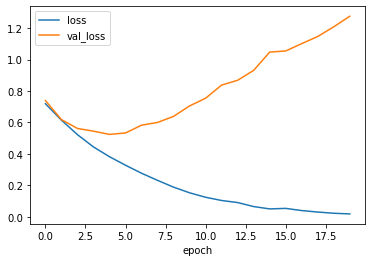

In [73]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.legend()
plt.show() 

In [76]:
import pickle
a_file = open("wordtoix_absa.pkl", "wb")
pickle.dump(wordtoix, a_file)
a_file.close()

In [181]:
def predict_aspect_pol(text):
    token_sample = word_processing(text)
    X_predict=[wordtoix[word] for word in token_sample]
    X_predict=sequence.pad_sequences([X_predict],max_length)
    predict= model.predict(X_predict)
    
    i = 0
    label_aspect_pred_lst= []
    for pred in predict[0][0]:
        if pred > 0.0002 :
    #         print(label_aspect_rev[i])
            label_aspect_pred_lst.append(label_aspect_rev[i])
        i = i+1
        
    j =0 
    label_pol_aspect_dict ={}
    for pre_pol in predict[1][0]:
        if pre_pol.argmax() != 0:
    #         print(label_aspect_rev[i],pre_pol.argmax())
            label_pol_aspect_dict[label_aspect_rev[j]]= label_polarity_rev[pre_pol.argmax()]

        j = j +1
    
    for label in label_pol_aspect_dict.keys():
        if label in label_aspect_pred_lst:
            print(label,label_pol_aspect_dict[label])

In [190]:
text = 'quán xa phục vụ lại chậm'

In [191]:
predict_aspect_pol(text)

SERVICE#GENERAL NEG


In [194]:
model.save("best_model_absa.h5")

ValueError: Unable to create dataset (name already exists)

# Model Transformer

In [162]:
from tensorflow.keras import layers

# soruce:(https://keras.io/examples/nlp/text_classification_with_transformer/)
from keras.initializers import Constant

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation='tanh'), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config

In [163]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
  

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "maxlen": self.maxlen,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

    
   

In [164]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # 
vocab_size = len(wordtoix)

In [165]:
inputs = layers.Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.5)(x)
aspect_output = layers.Dense(12, activation="sigmoid",name ='output_aspect')(x)

output_pol1 = Dense(4,activation = 'softmax',)(x)
output_pol1 = Reshape((-1,4))(output_pol1)

output_pol2 = Dense(4,activation = 'softmax')(x)
output_pol2 = Reshape((-1,4))(output_pol2)

output_pol3 = Dense(4,activation = 'softmax')(x)
output_pol3 = Reshape((-1,4))(output_pol3)

output_pol4 = Dense(4,activation = 'softmax')(x)
output_pol4 = Reshape((-1,4))(output_pol4)

output_pol5 = Dense(4,activation = 'softmax')(x)
output_pol5 = Reshape((-1,4))(output_pol5)

output_pol6 = Dense(4,activation = 'softmax')(x)
output_pol6 = Reshape((-1,4))(output_pol6)

output_pol7 = Dense(4,activation = 'softmax')(x)
output_pol7 = Reshape((-1,4))(output_pol7)

output_pol8 = Dense(4,activation = 'softmax')(x)
output_pol8 = Reshape((-1,4))(output_pol8)

output_pol9 = Dense(4,activation = 'softmax')(x)
output_pol9 = Reshape((-1,4))(output_pol9)

output_pol10 = Dense(4,activation = 'softmax')(x)
output_pol10 = Reshape((-1,4))(output_pol10)

output_pol11 = Dense(4,activation = 'softmax')(x)
output_pol11 = Reshape((-1,4))(output_pol11)

output_pol12 = Dense(4,activation = 'softmax')(x)
output_pol12 = Reshape((-1,4))(output_pol12)

output_pol = concatenate([output_pol1,output_pol2,output_pol3,output_pol4,output_pol5,
                    output_pol6,output_pol7,output_pol8,output_pol9,output_pol10,output_pol11,output_pol12],name='output_polarity',axis = 1)

model2 = Model(inputs = inputs ,outputs =[aspect_output,output_pol])


In [166]:
model2.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 88)]         0           []                               
                                                                                                  
 token_and_position_embedding_9  (None, 88, 32)      72064       ['input_14[0][0]']               
  (TokenAndPositionEmbedding)                                                                     
                                                                                                  
 transformer_block_6 (Transform  (None, 88, 32)      10656       ['token_and_position_embedding_9[
 erBlock)                                                        0][0]']                          
                                                                                            

                                                                                                  
Total params: 84,640
Trainable params: 84,640
Non-trainable params: 0
__________________________________________________________________________________________________


In [167]:
loss = {'output_aspect' : "binary_crossentropy" , 'output_polarity': 'categorical_crossentropy'}
model2.compile(optimizer='adam', loss=loss,loss_weights=[0.1,1])

In [168]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_aspect_train,y_aspect_test,y_pol_train,y_pol_test = train_test_split(X,y_aspect,y_polarity,test_size= 0.1 ,random_state=42)

In [169]:
history = model2.fit(X_train,[y_aspect_train,y_pol_train],
                   batch_size=64,
                    epochs=20,
                    validation_data=[X_test, [y_aspect_test,y_pol_test]])

Epoch 1/20
36/36 [==============================] - 4s 59ms/step - loss: 1.4306 - output_aspect_loss: 0.7043 - output_polarity_loss: 1.3602 - val_loss: 1.2762 - val_output_aspect_loss: 0.6826 - val_output_polarity_loss: 1.2079
Epoch 2/20
36/36 [==============================] - 2s 46ms/step - loss: 1.2586 - output_aspect_loss: 0.6851 - output_polarity_loss: 1.1901 - val_loss: 1.0036 - val_output_aspect_loss: 0.6431 - val_output_polarity_loss: 0.9393
Epoch 3/20
36/36 [==============================] - 2s 46ms/step - loss: 1.0685 - output_aspect_loss: 0.6412 - output_polarity_loss: 1.0044 - val_loss: 0.8526 - val_output_aspect_loss: 0.5794 - val_output_polarity_loss: 0.7947
Epoch 4/20
36/36 [==============================] - 2s 46ms/step - loss: 0.9282 - output_aspect_loss: 0.5808 - output_polarity_loss: 0.8701 - val_loss: 0.7446 - val_output_aspect_loss: 0.5145 - val_output_polarity_loss: 0.6931
Epoch 5/20
36/36 [==============================] - 2s 46ms/step - loss: 0.8517 - output_asp

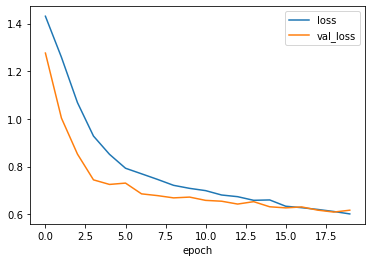

In [170]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.legend()
plt.show() 

In [171]:
model2.save('best_model_absa2.hdf5')